In [9]:
import pandas as pd

# Step 1: Load the CSV and skip the first row (which contains column names)
df = pd.read_csv('../datasets/iris.csv', skiprows=1)

# Step 2: Rename the columns properly
df.columns = ['Id', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# Step 3: Drop the Id column (not useful for classification)
df = df.drop('Id', axis=1)

# Step 4: Print first few rows to confirm
print(df.head())


   sepal_length  sepal_width  petal_length  petal_width      species
0           4.9          3.0           1.4          0.2  Iris-setosa
1           4.7          3.2           1.3          0.2  Iris-setosa
2           4.6          3.1           1.5          0.2  Iris-setosa
3           5.0          3.6           1.4          0.2  Iris-setosa
4           5.4          3.9           1.7          0.4  Iris-setosa


In [10]:
# Step 5: Encode species labels into numbers
df['species'] = df['species'].astype('category').cat.codes

# Step 6: Split features and labels
X = df.drop('species', axis=1).values  # shape: (150, 4)
y = df['species'].values               # shape: (150,)

# Step 7: Print to check
print("Feature sample:", X[:5])
print("Label sample:", y[:5])


Feature sample: [[4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]]
Label sample: [0 0 0 0 0]


In [11]:
import sys
import os

# Add the parent directory (project root) to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [12]:
from utils.scaler import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the feature data and transform it
X_scaled = scaler.fit_transform(X)

# Print a few rows to check if the scaling worked
print("Scaled feature sample:", X_scaled[:5])


Scaled feature sample: [[-1.1483555  -0.11805969 -1.35396443 -1.32506301]
 [-1.3905423   0.34485856 -1.41098555 -1.32506301]
 [-1.51163569  0.11339944 -1.29694332 -1.32506301]
 [-1.02726211  1.27069504 -1.35396443 -1.32506301]
 [-0.54288852  1.9650724  -1.18290109 -1.0614657 ]]


In [13]:
from utils.utils import train_test_split_custom

# Split the data using your custom function (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split_custom(X_scaled, y, test_size=0.2, random_seed=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 120
Test set size: 29


In [14]:
import importlib
import ml_algorithms.k_nearest_neighbours_classification
importlib.reload(ml_algorithms.k_nearest_neighbours_classification)
from ml_algorithms.k_nearest_neighbours_classification import KNN

knn = KNN(k=3)  # You can change k to any value you like
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Predictions:", y_pred)
accuracy = knn.accuracy(X_test, y_test)
print(f"Accuracy on test set: {accuracy:.2f}%")


Predictions: [0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 2 2 1 1 2 2 0 2 2 0 1 2]
Accuracy on test set: 96.55%


Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[ 7  0  0]
 [ 0  8  1]
 [ 0  0 13]]


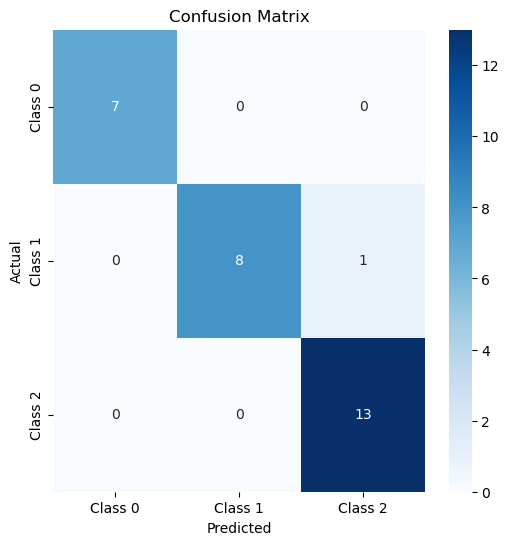

In [15]:
from utils.metrics import PrecisionScore, RecallScore, F1Score, ConfusionMatrix

# Step 1: Initialize your custom evaluation classes
precision_score = PrecisionScore()
recall_score = RecallScore()
f1_score = F1Score()
confusion_matrix = ConfusionMatrix(num_classes=3)

# Step 2: Compute precision, recall, and F1 score
precision = precision_score.compute(y_test, y_pred)
recall = recall_score.compute(y_test, y_pred)
f1 = f1_score.compute(precision, recall)

# Step 3: Print the scores
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Compute confusion matrix using true and predicted values
cm = confusion_matrix.compute(y_test, y_pred)

# Print the confusion matrix
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
confusion_matrix.plot()



## With K Fold Cross Validation 

In [16]:
# Import KFoldCrossValidation class
from utils.k_fold_cross_validation import KFoldCrossValidation
from ml_algorithms.k_nearest_neighbours_classification import KNN
from utils.metrics import PrecisionScore, RecallScore, F1Score, ConfusionMatrix
import numpy as np

# Initialize KFoldCrossValidation and KNN
kf = KFoldCrossValidation(k_folds=5)
knn = KNN(k=3)  # You can change k to any value you like

# Initialize metric evaluation classes
precision_score = PrecisionScore()
recall_score = RecallScore()
f1_score = F1Score()
confusion_matrix = ConfusionMatrix(num_classes=3)  # Assuming 3 classes (adjust if necessary)

# Perform K-Fold Cross Validation
avg_accuracy = kf.cross_validate(X_scaled, y, knn)
print(f"Average accuracy across {kf.k_folds} folds: {avg_accuracy * 100:.2f}%")

# If you want to evaluate other metrics like precision, recall, and F1 score for each fold:
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

for fold in kf.split(X_scaled, y):
    X_train, y_train, X_val, y_val = fold
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    
    # Evaluate metrics for each fold
    precision = precision_score.compute(y_val, y_pred)
    recall = recall_score.compute(y_val, y_pred)
    f1 = f1_score.compute(precision, recall)
    cm = confusion_matrix.compute(y_val, y_pred)
    
    # Append metrics for averaging later
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    confusion_matrices.append(cm)

# Print average precision, recall, and F1 score across folds
print(f"Average Precision: {np.mean(precision_scores):.2f}")
print(f"Average Recall: {np.mean(recall_scores):.2f}")
print(f"Average F1 Score: {np.mean(f1_scores):.2f}")

# Optionally, plot the confusion matrices for each fold (you can select a specific fold or summarize)
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i + 1}:\n{cm}")



Average accuracy across 5 folds: 93.52%
Average Precision: 0.98
Average Recall: 1.00
Average F1 Score: 0.99
Confusion Matrix for Fold 1:
[[ 5  0  0]
 [ 0 15  2]
 [ 0  0  7]]
Confusion Matrix for Fold 2:
[[ 7  1  0]
 [ 0 10  0]
 [ 0  3  8]]
Confusion Matrix for Fold 3:
[[14  0  0]
 [ 0  5  0]
 [ 0  1  9]]
Confusion Matrix for Fold 4:
[[10  0  0]
 [ 0 12  0]
 [ 0  0  7]]
Confusion Matrix for Fold 5:
[[12  0  0]
 [ 0  6  0]
 [ 0  1 14]]
